In [ ]:
# Vedh Jaishankar
# Uses LensKit 2025.2.0

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from lenskit.data import from_interactions_df, ItemListCollection, UserIDKey
from lenskit.splitting import SampleFrac, crossfold_users
from lenskit.als import BiasedMFScorer
from lenskit.batch import recommend
from lenskit.pipeline import topn_pipeline
from lenskit.metrics import NDCG, RunAnalysis, Precision, Recall

In [3]:
# 32M uses the same schema: userId,movieId,rating,timestamp
ratings = pd.read_csv("ml-latest-small/ratings.csv")
movies = pd.read_csv("ml-latest-small/movies.csv")

print(ratings.shape)   # ~32,000,204 rows
print(movies.shape)    # ~87,585 movies

(100836, 4)
(9742, 3)


In [4]:
# 1. Fractional sampling of users
frac = 1
sampled_users = ratings['userId'].drop_duplicates().sample(frac=frac, random_state=42)

# 2. Keep only ratings from sampled users
ratings_sampled = ratings[ratings['userId'].isin(sampled_users)]
print(f"Sampled ratings shape ({frac*100}% of users):", ratings_sampled.shape)

Sampled ratings shape (100% of users): (100836, 4)


In [5]:
als_model = BiasedMFScorer(features=65, iterations=15)  # adjust features/iterations as needed
pipe_als = topn_pipeline(als_model)

In [6]:
# Convert ratings DataFrame into LensKit interactions
# Assumes ratings.csv has columns: userId, movieId, rating, timestamp
dataset = from_interactions_df(
    ratings_sampled,
    user_col="userId",
    item_col="movieId",
    rating_col="rating",
    timestamp_col="timestamp"
)

In [7]:
all_test = ItemListCollection(UserIDKey)       # test data by user
all_recs = ItemListCollection(["user_id"])     # recs by user

# Use 2 folds + 20% sampling for quick test runs
for split in crossfold_users(dataset, 5, SampleFrac(1)):
    # collect test interactions
    all_test.add_from(split.test)

    # Train ALS model on training split
    fit_als = pipe_als.clone()
    fit_als.train(split.train)

    # generate recommendations (top-100 per user)
    als_recs = recommend(fit_als, split.test.keys(), 100)
    all_recs.add_from(als_recs)


2025-10-02 17:42:08 [warning  ] loaded pipeline does not match hash


C:\Users\Vedh\AppData\Roaming\Python\Python313\site-packages\lenskit\pipeline\_impl.py:233: PipelineWarning: loaded pipeline config does not match hash
  builder = PipelineBuilder.from_config(config)
C:\Users\Vedh\AppData\Roaming\Python\Python313\site-packages\lenskit\als\_explicit.py:58: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\SparseCsrTensorImpl.cpp:55.)
  rmat = rmat.to_sparse_csr()


2025-10-02 17:42:27 [warning  ] loaded pipeline does not match hash


C:\Users\Vedh\AppData\Roaming\Python\Python313\site-packages\lenskit\pipeline\_impl.py:233: PipelineWarning: loaded pipeline config does not match hash
  builder = PipelineBuilder.from_config(config)


2025-10-02 17:42:45 [warning  ] loaded pipeline does not match hash


C:\Users\Vedh\AppData\Roaming\Python\Python313\site-packages\lenskit\pipeline\_impl.py:233: PipelineWarning: loaded pipeline config does not match hash
  builder = PipelineBuilder.from_config(config)


2025-10-02 17:43:03 [warning  ] loaded pipeline does not match hash


C:\Users\Vedh\AppData\Roaming\Python\Python313\site-packages\lenskit\pipeline\_impl.py:233: PipelineWarning: loaded pipeline config does not match hash
  builder = PipelineBuilder.from_config(config)


2025-10-02 17:43:20 [warning  ] loaded pipeline does not match hash


C:\Users\Vedh\AppData\Roaming\Python\Python313\site-packages\lenskit\pipeline\_impl.py:233: PipelineWarning: loaded pipeline config does not match hash
  builder = PipelineBuilder.from_config(config)


In [8]:
recs_df = all_recs.to_df()  # columns: 'user', 'item', 'score'
test_df = all_test.to_df()  # columns: 'user', 'item', 'rating'

In [9]:
# Setup RunAnalysis for top-10 metrics
ran = RunAnalysis()
ran.add_metric(NDCG(k=10))
ran.add_metric(Precision(k=10))
ran.add_metric(Recall(k=10))

# Measure metrics on your recommendations
results = ran.measure(all_recs, all_test)

# Per-user metrics
print("Mean metrics by user_id:")
print(results.list_metrics().groupby("user_id").mean())

# Overall metrics
overall = results.list_metrics().groupby("user_id")[['NDCG@10','Precision@10','Recall@10']].mean().mean()
print("\nOverall Metrics @10")
print(overall)

Mean metrics by user_id:
          NDCG@10  Precision@10  Recall@10
user_id                                   
1        0.168780           0.2        0.2
2        0.313788           0.3        0.3
3        0.060037           0.1        0.1
4        0.345900           0.3        0.3
5        0.313788           0.3        0.3
...           ...           ...        ...
606      0.615336           0.6        0.6
607      0.422531           0.4        0.4
608      0.542605           0.5        0.5
609      0.190313           0.1        0.1
610      0.689220           0.6        0.6

[610 rows x 3 columns]

Overall Metrics @10
NDCG@10         0.250548
Precision@10    0.220000
Recall@10       0.220000
dtype: float64


In [10]:
# Setup RunAnalysis for top-10 metrics
ran = RunAnalysis()
ran.add_metric(NDCG(k=10))
ran.add_metric(Precision(k=10))
ran.add_metric(Recall(k=10))

# Measure metrics on your recommendations
results = ran.measure(all_recs, all_test)

# Per-user metrics
print("Mean metrics by user_id:")
print(results.list_metrics().groupby("user_id").mean())

# Overall metrics
overall = results.list_metrics().groupby("user_id")[['NDCG@10','Precision@10','Recall@10']].mean().mean()
print("\nOverall Metrics @10")
print(overall)

Mean metrics by user_id:
          NDCG@10  Precision@10  Recall@10
user_id                                   
1        0.168780           0.2        0.2
2        0.313788           0.3        0.3
3        0.060037           0.1        0.1
4        0.345900           0.3        0.3
5        0.313788           0.3        0.3
...           ...           ...        ...
606      0.615336           0.6        0.6
607      0.422531           0.4        0.4
608      0.542605           0.5        0.5
609      0.190313           0.1        0.1
610      0.689220           0.6        0.6

[610 rows x 3 columns]

Overall Metrics @10
NDCG@10         0.250548
Precision@10    0.220000
Recall@10       0.220000
dtype: float64


In [11]:
sample_user = ratings_sampled['userId'].iloc[10]

user_recs = recs_df[recs_df['user_id'] == sample_user].head(10)
top10 = user_recs.merge(movies, left_on="item_id", right_on="movieId")[["item_id","title","score"]]

print("\nTop 10 recommendations for sample user:")
print(top10)



Top 10 recommendations for sample user:
   item_id                                      title     score
0      318           Shawshank Redemption, The (1994)  4.430826
1     1104           Streetcar Named Desire, A (1951)  4.269537
2     1221             Godfather: Part II, The (1974)  4.258453
3      260  Star Wars: Episode IV - A New Hope (1977)  4.256809
4     1204                  Lawrence of Arabia (1962)  4.253826
5     1197                 Princess Bride, The (1987)  4.253523
6      904                         Rear Window (1954)  4.249052
7     1178                      Paths of Glory (1957)  4.231166
8      858                      Godfather, The (1972)  4.227962
9     1276                      Cool Hand Luke (1967)  4.225091


In [12]:
# Sample user
sample_user = ratings_sampled['userId'].iloc[0]

# Movies this user has already rated
user_history = ratings_sampled[ratings_sampled['userId'] == sample_user]

# Merge with movies DataFrame to get titles
user_history = user_history.merge(movies, left_on="movieId", right_on="movieId")[["movieId","title","rating"]]

# Sort by rating (highest first)
user_history = user_history.sort_values(by="rating", ascending=False)

print(f"Movies already rated by user {sample_user}:")
print(user_history.head(10))  # show top 10

Movies already rated by user 1:
    movieId                                   title  rating
3        47             Seven (a.k.a. Se7en) (1995)     5.0
4        50              Usual Suspects, The (1995)     5.0
6       101                    Bottle Rocket (1996)     5.0
13      231  Dumb & Dumber (Dumb and Dumber) (1994)     5.0
11      216                    Billy Madison (1995)     5.0
10      163                        Desperado (1995)     5.0
9       157                   Canadian Bacon (1995)     5.0
8       151                          Rob Roy (1995)     5.0
35      596                        Pinocchio (1940)     5.0
31      553                        Tombstone (1993)     5.0


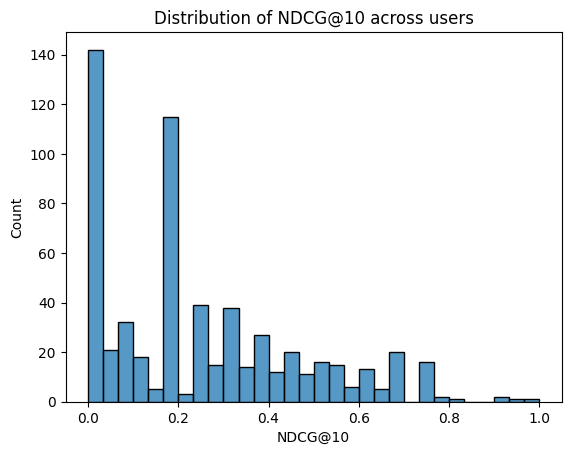

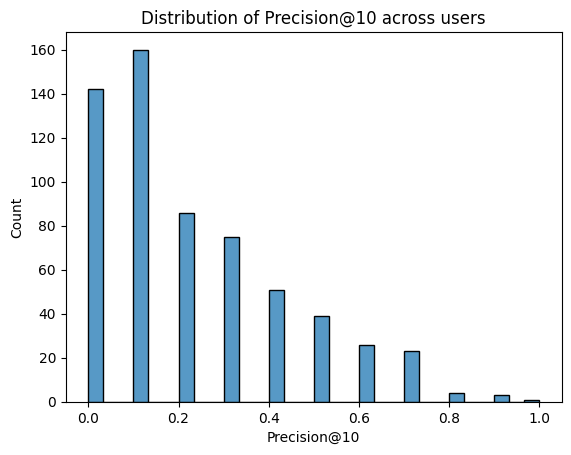

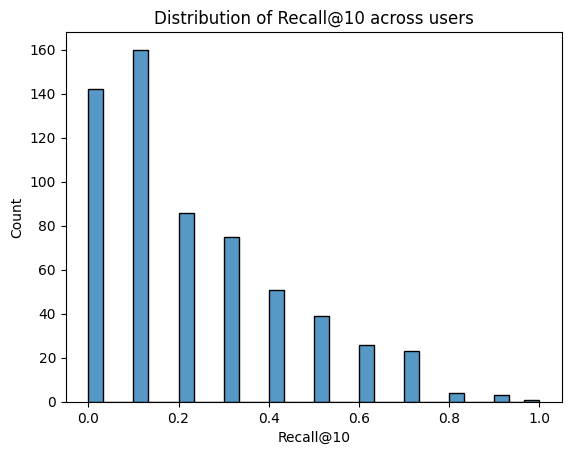

In [13]:
metrics_df = results.list_metrics().reset_index()

sns.histplot(metrics_df, x='NDCG@10', bins=30)
plt.title("Distribution of NDCG@10 across users")
plt.show()

sns.histplot(metrics_df, x='Precision@10', bins=30)
plt.title("Distribution of Precision@10 across users")
plt.show()

sns.histplot(metrics_df, x='Recall@10', bins=30)
plt.title("Distribution of Recall@10 across users")
plt.show()


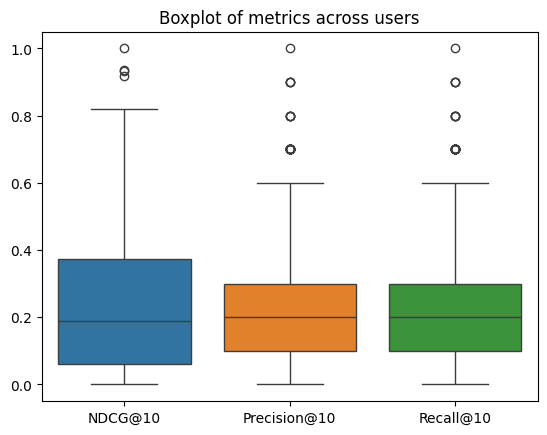

In [14]:
sns.boxplot(data=metrics_df[['NDCG@10','Precision@10','Recall@10']])
plt.title("Boxplot of metrics across users")
plt.show()

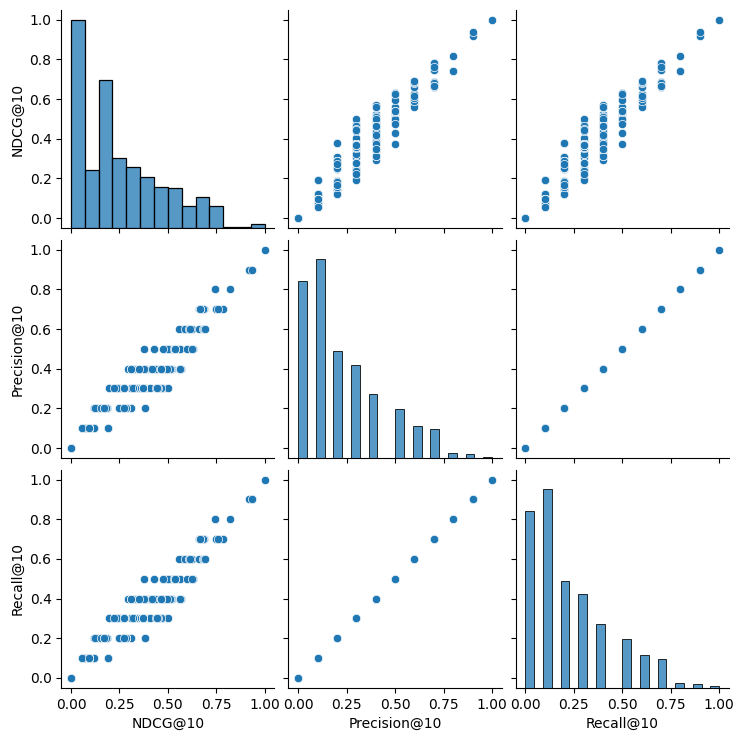

In [15]:
sns.pairplot(metrics_df[['NDCG@10','Precision@10','Recall@10']])
plt.show()

In [16]:
ratings_sampled.to_csv("ratings.csv", index=False)
movies.to_csv("movies.csv", index=False)
recs_df.to_csv("recs.csv", index=False)
metrics_df.to_csv("metrics.csv", index=False)
test_df.to_csv("test.csv", index=False)

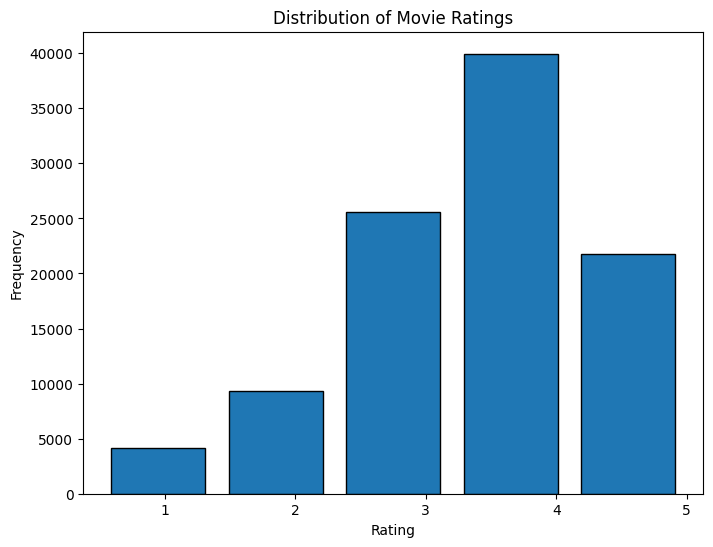

In [ ]:
# Histogram of ratings
plt.figure(figsize=(8,6))
plt.hist(ratings['rating'], bins=5, edgecolor='black', rwidth=0.8)

plt.title("Distribution of Movie Ratings")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.xticks([1, 2, 3, 4, 5])  


plt.show()